In [2]:
#!/usr/bin/env python3
"""
Alternative Collision Plots - Cleaner Visualizations
"""

import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import Dict, List
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.ioff()  # Turn off interactive mode

# Define model embedding dimensions
MODEL_EMBEDDING_DIMS = {
    'gpt2': 768,
    'gpt2-medium': 1024,
    'gpt2-large': 1280,
    'gemma-3-1b-pt': 2048,
    'gemma-3-4b-pt': 3072,
    'gemma-3-12b-pt': 3072,
}

class CollisionAnalyzer:
    def __init__(self, data_dir: str = "data/sampling_collisions"):
        self.data_dir = Path(data_dir)
        self.data = {}
        self.model_info = {}
        self.load_all_data()
        
    def load_all_data(self):
        """Load all CSV files and extract model information."""
        csv_files = list(self.data_dir.glob("*.csv"))
        
        for file in csv_files:
            model_name = file.stem.replace("-layer-stats", "")
            data_rows = []
            
            with open(file, 'r') as f:
                reader = csv.DictReader(f)
                for row in reader:
                    data_rows.append({
                        'layer': int(row['layer']),
                        'count': int(row['count']),
                        'mean': float(row['mean']),
                        'std': float(row['std']),
                        'min': float(row['min']),
                        'max': float(row['max'])
                    })
            
            self.data[model_name] = data_rows
            self.model_info[model_name] = self._extract_model_info(model_name)
    
    def _extract_model_info(self, model_name: str) -> Dict:
        """Extract model family, size, and other metadata."""
        model_name_lower = model_name.lower()
        
        # Get embedding dimension
        embedding_dim = MODEL_EMBEDDING_DIMS.get(model_name, 768)
        
        if "gpt2" in model_name_lower:
            family = "GPT2"
            if "large" in model_name_lower:
                size = "Large"
            elif "medium" in model_name_lower:
                size = "Medium" 
            else:
                size = "Small"
        elif "gemma" in model_name_lower:
            family = "Gemma"
            if "12b" in model_name_lower:
                size = "12B"
            elif "4b" in model_name_lower:
                size = "4B"
            elif "1b" in model_name_lower:
                size = "1B"
        else:
            family = "Unknown"
            size = "Unknown"
            
        return {
            "family": family,
            "size": size,
            "embedding_dim": embedding_dim,
            "full_name": model_name
        }

def get_model_data():
    """Get data for the selected models."""
    analyzer = CollisionAnalyzer()
    
    model_mapping = {
        'gpt2': 'GPT2-Small',
        'gpt2-medium': 'GPT2-Medium', 
        'gpt2-large': 'GPT2-Large',
        'gemma-3-1b-pt': 'Gemma-1B',
        'gemma-3-4b-pt': 'Gemma-4B',
        'gemma-3-12b-pt': 'Gemma-12B'
    }
    
    data = []
    labels = []
    
    for model_key, display_name in model_mapping.items():
        if model_key in analyzer.data:
            data_rows = analyzer.data[model_key]
            min_distances = [row['min'] for row in data_rows]
            data.append(min_distances)
            labels.append(display_name)
    
    return data, labels

def create_swarm_plot():
    """Option 1: Swarm plot - shows every data point clearly without overlap"""
    data, labels = get_model_data()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e']
    
    all_points_x = []
    all_points_y = []
    all_colors = []
    
    for i, (distances, color) in enumerate(zip(data, colors)):
        # Create x positions with smart spacing to avoid overlap
        y_vals = sorted(distances)
        x_vals = []
        
        for j, y in enumerate(y_vals):
            # Create a slight horizontal spread based on position in sorted list
            base_x = i
            spread = 0.3
            offset = (j / len(y_vals) - 0.5) * spread
            x_vals.append(base_x + offset)
        
        all_points_x.extend(x_vals)
        all_points_y.extend(y_vals)
        all_colors.extend([color] * len(y_vals))
    
    # Plot all points
    scatter = ax.scatter(all_points_x, all_points_y, c=all_colors, alpha=0.7, s=40)
    
    ax.set_yscale('log')
    ax.set_xlabel('Models')
    ax.set_ylabel('Minimum Distance (log scale)')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # Add collision threshold
    ax.axhline(y=1e-6, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax.text(0.02, 0.02, 'Practical collision threshold ≈ 1e-6', 
             transform=ax.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.3),
             fontsize=10)
    
    plt.tight_layout()
    plt.savefig('collision_plots/swarm_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_box_plot():
    """Option 2: Clean box plot showing quartiles and outliers"""
    data, labels = get_model_data()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Create box plot
    box_parts = ax.boxplot(data, labels=labels, patch_artist=True, 
                          showfliers=True, notch=True)
    
    # Color the boxes
    colors = ['#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e']
    for patch, color in zip(box_parts['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_yscale('log')
    ax.set_xlabel('Models')
    ax.set_ylabel('Minimum Distance (log scale)')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Add collision threshold
    ax.axhline(y=1e-6, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax.text(0.02, 0.02, 'Practical collision threshold ≈ 1e-6', 
             transform=ax.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.3),
             fontsize=10)
    
    plt.tight_layout()
    plt.savefig('collision_plots/box_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_strip_plot():
    """Option 3: Strip plot with jitter - simple and clear"""
    data, labels = get_model_data()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = ['#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e']
    
    for i, (distances, color) in enumerate(zip(data, colors)):
        # Add jitter to x-coordinates
        x_vals = np.random.normal(i, 0.1, len(distances))
        ax.scatter(x_vals, distances, color=color, alpha=0.6, s=50)
    
    ax.set_yscale('log')
    ax.set_xlabel('Models')
    ax.set_ylabel('Minimum Distance (log scale)')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # Add collision threshold
    ax.axhline(y=1e-6, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax.text(0.02, 0.02, 'Practical collision threshold ≈ 1e-6', 
             transform=ax.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.3),
             fontsize=10)
    
    plt.tight_layout()
    plt.savefig('collision_plots/strip_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_summary_bar_plot():
    """Option 4: Bar plot showing min/max range with mean marker"""
    data, labels = get_model_data()
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Calculate statistics
    mins = [min(d) for d in data]
    maxs = [max(d) for d in data]
    means = [np.mean(d) for d in data]
    
    colors = ['#1f77b4', '#1f77b4', '#1f77b4', '#ff7f0e', '#ff7f0e', '#ff7f0e']
    
    x_pos = range(len(labels))
    
    # Create bar plot showing range from min to max
    for i, (min_val, max_val, mean_val, color) in enumerate(zip(mins, maxs, means, colors)):
        ax.bar(i, max_val - min_val, bottom=min_val, color=color, alpha=0.6, width=0.6)
        # Add mean marker
        ax.plot(i, mean_val, 'ro', markersize=8, markerfacecolor='red', markeredgecolor='darkred')
    
    ax.set_yscale('log')
    ax.set_xlabel('Models')
    ax.set_ylabel('Minimum Distance (log scale)')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.grid(True, alpha=0.3)
    
    # Add legend for mean markers
    ax.plot([], [], 'ro', markersize=8, label='Mean', markerfacecolor='red', markeredgecolor='darkred')
    ax.legend()
    
    # Add collision threshold
    ax.axhline(y=1e-6, color='red', linestyle='--', alpha=0.7, linewidth=2)
    ax.text(0.02, 0.02, 'Practical collision threshold ≈ 1e-6', 
             transform=ax.transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.3),
             fontsize=10)
    
    plt.tight_layout()
    plt.savefig('collision_plots/bar_plot.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

1. Creating swarm plot (shows every point clearly)...


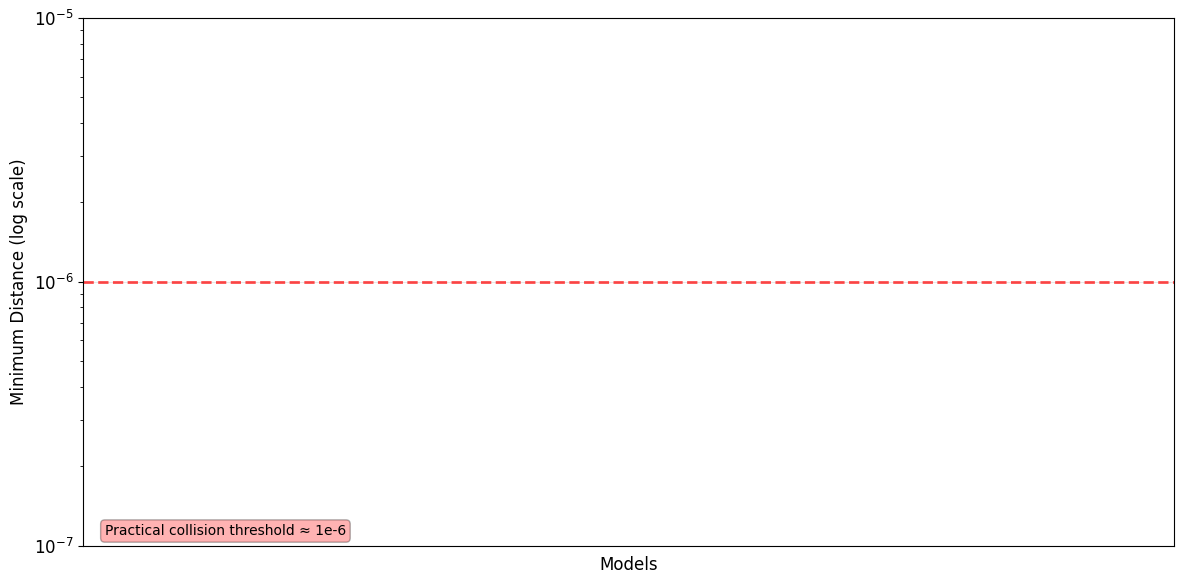

2. Creating box plot (shows quartiles and outliers)...


ValueError: Dimensions of labels and X must be compatible

In [3]:
# Create output directory
output_dir = Path("collision_plots")
output_dir.mkdir(exist_ok=True)

print("1. Creating swarm plot (shows every point clearly)...")
create_swarm_plot()

print("2. Creating box plot (shows quartiles and outliers)...")
create_box_plot()

print("3. Creating strip plot (simple jittered points)...")
create_strip_plot()

print("4. Creating bar plot (shows min-max range with means)...")
create_summary_bar_plot()